# IDS 576: Assignment 2
Patricia Maya 

"In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest."

We will use the pretrained Resnet18 model (from trochvision) to do Transfer Learning using the CIFAR-10 dataset. There are two ways to use pre-trained networks:
1. Feature Extraction
2. Fine-Tuning

### 1. CNNs and finetuning

 -  Download the CIFAR 10 dataset (original data can be found [here](http://www.cs.toronto.edu/~kriz/cifar.html), and here is a link to the  pickled [python version](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz). )


The CIFAR-10 dataset consists of 60,000 32x32 colour images in 10 classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images.

Here are the classes in the dataset: 
  - airplane 
  - automobile 
  - bird 
  - cat 
  - deer 
  - dog 
  - frog 
  - horse 
  - ship 
  - truck


In [2]:
import pandas as pd
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models
import torchvision.transforms as T
import matplotlib.pyplot as plt
import time
import os
import copy
from keras.datasets import cifar10
from torch.utils.data import SubsetRandomSampler
from torch.utils.data import DataLoader

In [11]:
#code adapted from https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
from torch.utils.data import sampler

# Data augmentation and normalization for training 
# Just normalization for validation
data_transforms = {
    'train': T.Compose([
          T.RandomResizedCrop(224),
          T.ColorJitter(hue=.05, saturation=.05),
          T.RandomHorizontalFlip(),
          T.ToTensor(),
          T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    'val': T.Compose([
          T.Resize(256),
          T.CenterCrop(224),
          T.ToTensor(),
          T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])
}

data_size = {
    'train': range(42500),
    'val': range(42500, 50000),
}

image_datasets = {x: datasets.CIFAR10('./datasets', train=True, download=True,
                                      transform=data_transforms[x]) for x in ['train', 'val']}

image_dataloaders = {x: DataLoader(image_datasets[x], batch_size=64, 
                                   sampler=sampler.SubsetRandomSampler(data_size[x]), num_workers=8) for x in ['train', 'val']}

class_names = image_datasets['train'].classes
print(class_names)
#####

Files already downloaded and verified
Files already downloaded and verified
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

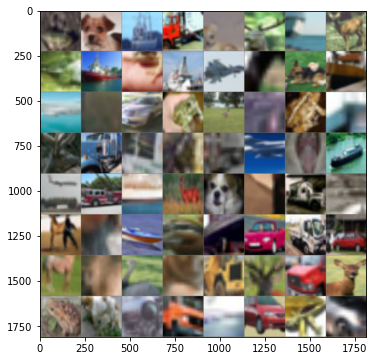

In [13]:
def imshow(inp, title=None, ax=None, figsize=(5, 5)):
  """Imshow for Tensor."""
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  if ax is None:
    fig, ax = plt.subplots(1, figsize=figsize)
  ax.imshow(inp)

# Get a batch of training data
inputs, classes = next(iter(image_dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=8)

fig, ax = plt.subplots(1, figsize=(6, 6))
imshow(out, ax=ax)

In [16]:
#function that trains model
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())          
    best_acc = 0.0                                              

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for i, (inputs, labels) in enumerate(image_dataloaders[phase]):
              inputs, labels = inputs.to(device), labels.to(device)                                        

                # zero the parameter gradients
              optimizer.zero_grad()

                # forward
                # track history if only in train
              with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)                                        
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
              running_loss += loss.item() * inputs.size(0)
              running_corrects += (preds == labels).sum()

            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / len(data_size[phase])
            epoch_acc = running_corrects.double() / len(data_size[phase])

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:                           
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()
 
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))               

    # load best model weights
    model.load_state_dict(best_model_wts)                                         
    return model

In [17]:
#function to get predictions for some images
def visualize_model(model, device, rows=2, cols=4):
  was_training = model.training
  model.eval()
  current_row = current_col = 0
  fig, ax = plt.subplots(rows, cols, figsize=(cols*2, rows*2))

  with torch.no_grad():
    for idx, (imgs, lbls) in enumerate(image_dataloaders['val']):
      imgs = imgs.to(device)
      lbls = lbls.to(device)

      outputs = model(imgs)
      _, preds = torch.max(outputs, 1)
    
      for j in range(imgs.size(0)):
        imshow(imgs.data.cpu()[j], ax=ax[current_row, current_col])
        ax[current_row, current_col].axis('off')
        ax[current_row, current_col].set_title('predicted: {}'.format(class_names[preds.cpu()[j]]))

        current_col += 1
        if current_col >= cols:
          current_row += 1
          current_col = 0
        if current_row >= rows:
          model.train(mode=was_training)
          return
    model.train(mode=was_training) 

-  Use the pretrained Resnet18 model (from trochvision) to extract features. Use the features as inputs in a new multi-class logistic regression model (use nn.Linear/ nn.Module to define your model)
	 -(a) Describe any choices made and report test performance.
	 -(b) Display the top 5 correct predictions and the top 5 incorrect predictions in each class (show the images and the prediction labels) compactly.


**Transfer by Feature Extraction Steps:** 

1. Get a pretrained CNN
2. Remove the last FC 
3. Pass new training data to get embeddings

We can think of the penultimate hidden layer activations as an embedding of the image. 

This is the activation vector or the representation or the CNN code of the image

In [18]:
# Feature Extractor (CNN Codes)
resnet18 = torchvision.models.resnet18(pretrained=True)
for param in resnet18.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
number_features = resnet18.fc.in_features
resnet18.fc = nn.Linear(number_features, 10) # CIFAR10 dataset has 10 classes
                                             #nn.Linear -- fully connected

resnet18 = resnet18.to(device) # Using GPU
criterion = nn.CrossEntropyLoss()

resnet18.fc.weight.requires_grad = True     #requires_grad flag set to True in order to be able to compute derivatives.
resnet18.fc.bias.requires_grad = True

resnet18 = resnet18.to(device)

# ONLY parameters of final layer are being optimized 
optimizer_conv = optim.SGD(resnet18.fc.parameters(), lr=0.001, momentum=0.9) 
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [8]:
new_model_resnet18 = train_model(resnet18, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=15)

Epoch 0/14
----------
train Loss: 1.5187 Acc: 0.4841
val Loss: 0.9183 Acc: 0.7072

Epoch 1/14
----------
train Loss: 1.2562 Acc: 0.5677
val Loss: 0.8271 Acc: 0.7272

Epoch 2/14
----------
train Loss: 1.2105 Acc: 0.5780
val Loss: 0.7975 Acc: 0.7329

Epoch 3/14
----------
train Loss: 1.1849 Acc: 0.5876
val Loss: 0.7896 Acc: 0.7260

Epoch 4/14
----------
train Loss: 1.1770 Acc: 0.5899
val Loss: 0.7439 Acc: 0.7460

Epoch 5/14
----------
train Loss: 1.1700 Acc: 0.5931
val Loss: 0.7381 Acc: 0.7496

Epoch 6/14
----------
train Loss: 1.1596 Acc: 0.5942
val Loss: 0.7403 Acc: 0.7487

Epoch 7/14
----------
train Loss: 1.1380 Acc: 0.6041
val Loss: 0.7305 Acc: 0.7516

Epoch 8/14
----------
train Loss: 1.1433 Acc: 0.6030
val Loss: 0.7198 Acc: 0.7524

Epoch 9/14
----------
train Loss: 1.1434 Acc: 0.6007
val Loss: 0.7251 Acc: 0.7512

Epoch 10/14
----------
train Loss: 1.1444 Acc: 0.6005
val Loss: 0.7593 Acc: 0.7433

Epoch 11/14
----------
train Loss: 1.1412 Acc: 0.5991
val Loss: 0.7421 Acc: 0.7492

Ep

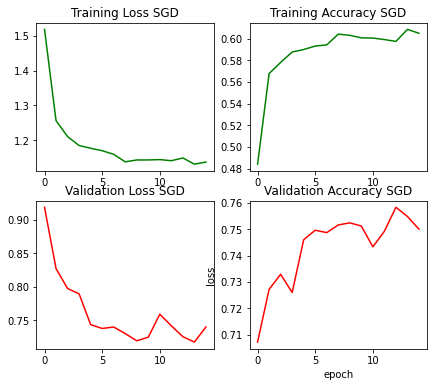

In [11]:
train_losses= [1.5187, 1.2562, 1.2105, 1.1849, 1.1770, 1.1700, 1.1596, 1.1380, 1.1433, 1.1434, 1.1444, 1.1412, 1.1491, 1.1313, 1.1373]
train_accs  = [0.4841, 0.5677, 0.5780, 0.5876, 0.5899, 0.5931, 0.5942, 0.6041, 0.6030, 0.6007, 0.6005, 0.5991, 0.5974, 0.6085, 0.6049]
val_losses  = [0.9183, 0.8271, 0.7975, 0.7896, 0.7439, 0.7381, 0.7403, 0.7305, 0.7198, 0.7251, 0.7593, 0.7421, 0.7259, 0.7179, 0.7403]
val_accs    = [0.7072, 0.7272, 0.7329, 0.7260, 0.7460, 0.7496, 0.7487, 0.7516, 0.7524, 0.7512, 0.7433, 0.7492, 0.7583, 0.7548, 0.7500]

fig, axs = plt.subplots(2,2,figsize=(7,6))
plt.xlabel('epoch')
plt.ylabel('loss')
axs[0,0].plot(train_losses, color='green')
axs[0,0].set_title("Training Loss SGD")
axs[0,1].plot(train_accs, color='green')
axs[0,1].set_title("Training Accuracy SGD")
axs[1,0].plot(val_losses, color='red')
axs[1,0].set_title("Validation Loss SGD")
axs[1,1].plot(val_accs, color='red')
axs[1,1].set_title("Validation Accuracy SGD")
plt.show()

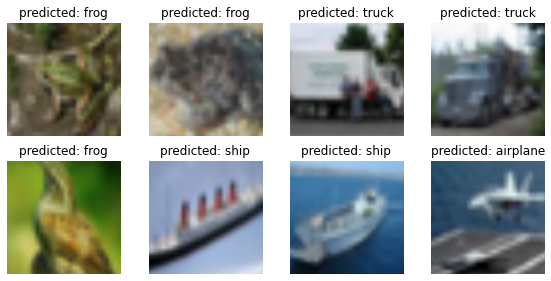

In [12]:
visualize_model(new_model_resnet18, device=device)
plt.tight_layout()

-  Finetune the Resnet18 model's parameters suitably and repeat parts (a) and (b) from above. Compare the performance of finetuning versus using extracted features.

Finetuning the convnet
Load a pretrained model and reset final fully connected layer.

In [80]:
# Fine-Tuning
ft_resnet18 = torchvision.models.resnet18(pretrained=True, progress=True)
num_features = ft_resnet18.fc.in_features
ft_resnet18.fc = nn.Linear(num_features, 10)  # CIFAR10 dataset has 10 classes

ft_resnet18 = ft_resnet18.to(device) #to use gpu

criterion = nn.CrossEntropyLoss()

# the whole resnet18 network is being fine-tuned, also all of its parameters are passed to the optimizer
optimizer_ft = optim.SGD(ft_resnet18.parameters(), lr=0.001, momentum=0.9) 

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [81]:
new_model_resnet18 = train_model(ft_resnet18, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=15)

Epoch 0/14
----------
train Loss: 1.0424 Acc: 0.6388
val Loss: 0.3364 Acc: 0.8884

Epoch 1/14
----------
train Loss: 0.6713 Acc: 0.7668
val Loss: 0.2454 Acc: 0.9156

Epoch 2/14
----------
train Loss: 0.5931 Acc: 0.7929
val Loss: 0.2218 Acc: 0.9265

Epoch 3/14
----------
train Loss: 0.5478 Acc: 0.8105
val Loss: 0.1971 Acc: 0.9337

Epoch 4/14
----------
train Loss: 0.5192 Acc: 0.8199
val Loss: 0.1938 Acc: 0.9327

Epoch 5/14
----------
train Loss: 0.4953 Acc: 0.8291
val Loss: 0.1728 Acc: 0.9380

Epoch 6/14
----------
train Loss: 0.4784 Acc: 0.8329
val Loss: 0.1646 Acc: 0.9423

Epoch 7/14
----------
train Loss: 0.4486 Acc: 0.8442
val Loss: 0.1545 Acc: 0.9453

Epoch 8/14
----------
train Loss: 0.4299 Acc: 0.8517
val Loss: 0.1544 Acc: 0.9459

Epoch 9/14
----------
train Loss: 0.4271 Acc: 0.8514
val Loss: 0.1506 Acc: 0.9477

Epoch 10/14
----------
train Loss: 0.4264 Acc: 0.8520
val Loss: 0.1493 Acc: 0.9480

Epoch 11/14
----------
train Loss: 0.4211 Acc: 0.8554
val Loss: 0.1502 Acc: 0.9477

Ep

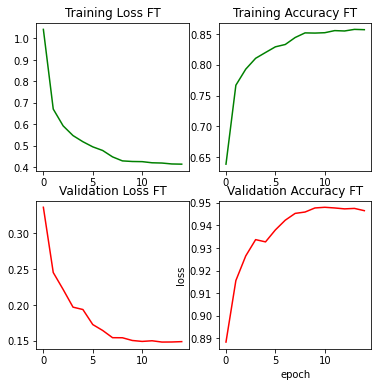

In [94]:
train_losses_ft= [ 1.0424, 0.6713, 0.5931, 0.5478, 0.5192, 0.4953, 0.4784, 0.4486, 0.4299, 0.4271, 0.4264, 0.4211, 0.4199, 0.4156, 0.4147]
val_losses_ft  = [ 0.3364, 0.2454, 0.2218, 0.1971, 0.1938, 0.1728, 0.1646, 0.1545, 0.1544, 0.1506, 0.1493, 0.1502, 0.1484, 0.1485, 0.1490]
train_accs     = [0.6388, 0.7668, 0.7929, 0.8105, 0.8199, 0.8291, 0.8329, 0.8442, 0.8517, 0.8514,  0.8520, 0.8554, 0.8548, 0.8574, 0.8569]
val_accs       = [0.8884, 0.9156, 0.9265, 0.9337, 0.9327, 0.9380, 0.9423, 0.9453, 0.9459, 0.9477,  0.9480, 0.9477, 0.9473, 0.9475, 0.9465]
fig, axs = plt.subplots(2,2,figsize=(6,6))
axs[0,0].plot(train_losses_ft, color='green')
axs[0,0].set_title("Training Loss FT")
axs[0,1].plot(train_accs, color='green')
axs[0,1].set_title("Training Accuracy FT")
axs[1,0].plot(val_losses_ft, color='red')
axs[1,0].set_title("Validation Loss FT")
axs[1,1].plot(val_accs, color='red')
axs[1,1].set_title("Validation Accuracy FT")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

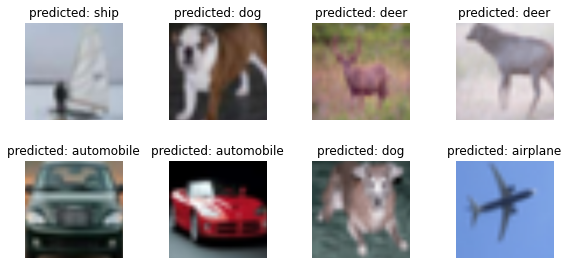

In [90]:
visualize_model(new_model_resnet18, device=device)
plt.tight_layout()
plt.show()

### 2. Movie embeddings (4pt)

Instead of embedding words, we will embed movies.  In particular, if we can embed movies, then similar movies will be close to each other and can be recommended.  This line of reasoning  is analogous to the [distributional hypothesis of word meanings](https://en.wikipedia.org/wiki/Distributional_semantics). For words, this roughly translates to words that appear in similar sentences should have similar vector representations. For movies, vectors for two movies should be similar if they are watched by similar people. 

Let the total number of movies be $M$. Let $X_{i,j}$ be the number of users that liked both movies $i$ and $j$. We want to obtain vectors $v_1,...,v_i,...,v_j,...,v_M$ for all movies such that we minimize the cost $c(v_1,...,v_M) = \sum_{i=1}^{M}\sum_{j=1}^{M}\mathbf{1}_{[i\neq j]}(v_i^Tv_j - X_{i,j})^2$. Here $\mathbf{1}_{[i\neq j]}$ is a function that is $0$ when $i=j$ and $1$ otherwise.


 -  Compute data $X_{i,j}$ from the movielens (small) [dataset](http://files.grouplens.org/datasets/movielens/ml-latest-small.zip) and [description](http://files.grouplens.org/datasets/movielens/ml-latest-small-README.html). Briefly describe your data prep workflow (you can use `pandas` if needed).


Dataset contains 100,836 ratings and 3,683 tag applications across 9,742 movies. These data were created by 610 users between March 29, 1996 and September 24, 2018. This dataset was generated on September 26, 2018.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
#loading datasets as pandas dataframes
movies = pd.read_csv('/content/drive/My Drive/ml-latest-small/movies.csv')
ratings = pd.read_csv('/content/drive/My Drive/ml-latest-small/ratings.csv')
tags = pd.read_csv('/content/drive/My Drive/ml-latest-small/tags.csv')

In [6]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [8]:
#we have 9,742 movies in total from the dataset. Thus, we have 9,742 choose 2 = 47,448,411 movie pairs.
print(ratings['movieId'].nunique()) #only 9724 rated

9724


In [9]:
print(ratings['rating'].describe())

count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64


(array([ 1370.,  2811.,  1791.,  7551.,  5550., 20047., 13136., 26818.,
         8551., 13211.]),
 array([0.5 , 0.95, 1.4 , 1.85, 2.3 , 2.75, 3.2 , 3.65, 4.1 , 4.55, 5.  ]),
 <a list of 10 Patch objects>)

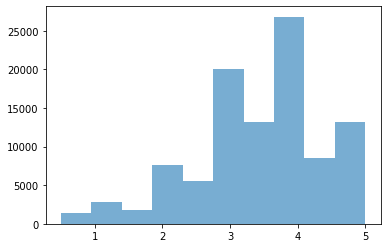

In [10]:
plt.hist(ratings['rating'], alpha=0.6)

In [8]:
#Since we want 𝑋𝑖,𝑗 to be the number of users that liked both movies 𝑖 and 𝑗, we need to set a treshold for whether a user likes a movie or not. 
ratings_df = ratings 
movies_df = movies 

mean_median = ratings_df.groupby(['userId']).rating.agg(['mean', 'median'])
ratings_df = ratings_df.set_index('userId').join(mean_median)

ratings_df.head(3)

# We will use the mean as our treshold. If the movie rating >= mean rating, we will say the movie was liked by the user. 
# Add this as Liked == 1 / Not Liked == 0   
# np.where(condition, value if condition is true, value if condition is false)
ratings_df['Liked_Movie'] = np.where(ratings_df['rating'] >= ratings_df['mean'], 1, 0)
ratings_df.head()

#Cleaning df
columns = ['rating', 'timestamp', 'mean','median']
ratings_df.drop(columns, inplace=True, axis=1)
ratings_df.head()

,movieId,Liked_Movie
userId,,
1,1,0
1,3,0
1,6,0
1,47,1
1,50,1


In [9]:
#Xij should be a symmetric matrix nxn = 9742 x 9742. 
#Where (i,j) contains the number of users that liked both movies 𝑖 and 𝑗.

print(ratings_df['movieId'].nunique())
  #we can see NOT all movies were rated. only 9724

# Create userId column from index so that it's preserved after the join
ratings_df['userId'] = ratings_df.index

#join ratings_df with movies_df to account for the movies not rated. 
merged_df = pd.merge(ratings_df, movies_df, on='movieId', how = 'right')
print(merged_df['movieId'].nunique())
  #now all 9742 movies are in the df 

#Cleaning merged df
columns2 = ['title', 'genres']
merged_df.drop(columns2, inplace=True, axis=1)
merged_df.head()

9724
9742


,movieId,Liked_Movie,userId
0,1,0.0,1.0
1,1,1.0,5.0
2,1,1.0,7.0
3,1,0.0,15.0
4,1,1.0,17.0


In [10]:
#new df. user id vs movie id -- 1 where user i liked movie j 
df = pd.crosstab(merged_df.userId, merged_df.movieId, values= merged_df.Liked_Movie, aggfunc="sum", dropna=False)
df= df.fillna(0)
df.head(5)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#moving result to tensor on gpu for faster computation
df = torch.tensor(df.values, dtype=torch.float).to(device)
print(df.size())

torch.Size([610, 9742])


In [11]:
#transposing df -- now we have movies as rows and users as columns
df_transposed = df.transpose(0,1) #9742 X 610 
final_X = torch.mm(df_transposed, df).to(device) #matrix multiplication: df_transposed x df (9742,610) X (610,9742) = (9742,0742)
    #this mm gets us the num of users that liked both movie i and j 
print(final_X.size())
print(final_X)

torch.Size([9742, 9742])
tensor([[147.,  29.,  13.,  ...,   0.,   0.,   0.],
        [ 29.,  53.,   6.,  ...,   0.,   0.,   0.],
        [ 13.,   6.,  21.,  ...,   0.,   0.,   0.],
        ...,
        [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
        [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
        [  0.,   0.,   0.,  ...,   0.,   0.,   1.]], device='cuda:0')


In [12]:
#checking if final X works
new= pd.crosstab(merged_df.userId, merged_df.movieId, values= merged_df.Liked_Movie, aggfunc="sum", dropna=False)
new= new.fillna(0)
print(new[1].sum()) #147 users liked movie 1 --(1,1)
print(new[2].sum()) # 53 users liked movie 2 --(2,2)
print(new[3].sum()) # 21 users liked movie 3 --(3,3)
print(len(new.loc[(new[1] >= 1) & (new[2] >= 1)])) #29 users liked movie 1 & 2 -- (1,2) & (2,1)
print(len(new.loc[(new[1] >= 1) & (new[3] >= 1)])) #13 users liked movie 1 & 3 -- (1,3) & (3,1)
print(len(new.loc[(new[2] >= 1) & (new[3] >= 1)])) # 6 users liked movie 2 & 3 -- (2,3) & (3,2)

147.0
53.0
21.0
29
13
6


final_X is the data we will use. 


 -  Optimize function $c(v_1,...,v_M)$ over $v_1,...,v_M$ using gradient descent (using `pytorch` or `tensorflow`). Plot the loss as a function of iteration for various choices (learning rates, choice of optimizers etc).


 Remember: vectors $v_1,...,v_i,...,v_j,...,v_M$ for all movies such that we minimize the cost $c(v_1,...,v_M) = \sum_{i=1}^{M}\sum_{j=1}^{M}\mathbf{1}_{[i\neq j]}(v_i^Tv_j - X_{i,j})^2$. Here $\mathbf{1}_{[i\neq j]}$ is a function that is $0$ when $i=j$ and $1$ otherwise.

In [13]:
#code adapted from https://yonigottesman.github.io/recsys/pytorch/elasticsearch/2020/02/18/fm-torch-to-recsys.html

#Optimizing cost function using Adam optimizer and learning rates [ 1, .1, .01, .001, .0001]
num_movies = len(movies['movieId'])

#define class model - PyTorch artificial neural network
class M_Cost(nn.Module):
    def __init__(self):   
      super().__init__()
      self.weights = nn.Parameter(torch.randn(100, num_movies))         #start w/ random weights
    
    def forward(self, X):
      cost_r = ((self.weights.transpose(0,1) @ self.weights - X)**2)       # 1*(viT * vj - Xij)^2
      diagonal = cost_r * torch.eye(num_movies, num_movies).to(device)     #torch.eye : 2-D tensor with ones on the diagonal and zeros elsewhere
      return torch.sum(cost_r - diagonal)

#function that fits data to model
def fit(X, model, optimizer, epochs):
  losses =[]
  for epoch in range(epochs):
    loss = model.forward(X)
    optimizer.zero_grad()
    if epoch % 15 == 0:
      print('Epoch:', epoch , 'Loss:', loss.item() )
      losses.append(loss.item())
    loss.backward()             #backpropagation by auto-differentiation
    optimizer.step()
  return losses 

costs =[]
epochs = 150
learning_rates = [ 1, .1, .01, .001, .0001]
for i in learning_rates:
    model = M_Cost().to(device)
    print('Learning Rate:', i)
    optimizer = optim.Adam(model.parameters(), lr = i)
    costs.append(fit(final_X, model, optimizer, epochs))

Learning Rate: 1
Epoch: 0 Loss: 9608085504.0
Epoch: 15 Loss: 343361920.0
Epoch: 30 Loss: 66343448.0
Epoch: 45 Loss: 16037150.0
Epoch: 60 Loss: 6119142.0
Epoch: 75 Loss: 3047523.0
Epoch: 90 Loss: 1728895.0
Epoch: 105 Loss: 1141815.5
Epoch: 120 Loss: 882295.8125
Epoch: 135 Loss: 789188.125
Learning Rate: 0.1
Epoch: 0 Loss: 9572038656.0
Epoch: 15 Loss: 217736000.0
Epoch: 30 Loss: 58654960.0
Epoch: 45 Loss: 26775400.0
Epoch: 60 Loss: 15538562.0
Epoch: 75 Loss: 10575892.0
Epoch: 90 Loss: 7956133.5
Epoch: 105 Loss: 6356697.5
Epoch: 120 Loss: 5285243.0
Epoch: 135 Loss: 4479435.0
Learning Rate: 0.01
Epoch: 0 Loss: 9593370624.0
Epoch: 15 Loss: 5957888000.0
Epoch: 30 Loss: 3815060480.0
Epoch: 45 Loss: 2579597824.0
Epoch: 60 Loss: 1842607104.0
Epoch: 75 Loss: 1377051264.0
Epoch: 90 Loss: 1064302848.0
Epoch: 105 Loss: 840586624.0
Epoch: 120 Loss: 670996736.0
Epoch: 135 Loss: 539819648.0
Learning Rate: 0.001
Epoch: 0 Loss: 9620430848.0
Epoch: 15 Loss: 9173552128.0
Epoch: 30 Loss: 8749893632.0
Epoch

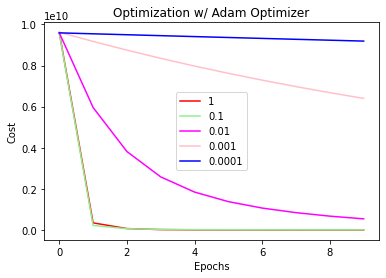

In [14]:
plt.title('Optimization w/ Adam Optimizer')
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.plot(costs[0], 'red' , label = learning_rates[0])
plt.plot(costs[1], 'lightgreen', label = learning_rates[1])
plt.plot(costs[2], 'magenta', label = learning_rates[2])
plt.plot(costs[3], 'pink' , label = learning_rates[3])
plt.plot(costs[4], 'blue' , label = learning_rates[4])
plt.legend()
plt.show()

In [18]:
#Optimizing cost function using RMSprop optimizer and learning rates [ 1, .1, .01, .001, .0001]
costs =[]
epochs = 150
learning_rates = [ 1, .1, .01, .001, .0001]
for i in learning_rates:
    model = M_Cost().to(device)
    print('Learning Rate:', i)
    optimizer = optim.RMSprop(model.parameters(), lr = i)
    costs.append(fit(final_X, model, optimizer, epochs))

Learning Rate: 1
Epoch: 0 Loss: 9598660608.0
Epoch: 15 Loss: 5088006144.0
Epoch: 30 Loss: 2904506880.0
Epoch: 45 Loss: 1849395200.0
Epoch: 60 Loss: 1266116352.0
Epoch: 75 Loss: 913575040.0
Epoch: 90 Loss: 686190208.0
Epoch: 105 Loss: 531655552.0
Epoch: 120 Loss: 421369472.0
Epoch: 135 Loss: 338194240.0
Learning Rate: 0.1
Epoch: 0 Loss: 9596653568.0
Epoch: 15 Loss: 35875828.0
Epoch: 30 Loss: 20081616.0
Epoch: 45 Loss: 12186645.0
Epoch: 60 Loss: 11727647.0
Epoch: 75 Loss: 8749282.0
Epoch: 90 Loss: 10706078.0
Epoch: 105 Loss: 7233082.0
Epoch: 120 Loss: 8517642.0
Epoch: 135 Loss: 5649562.0
Learning Rate: 0.01
Epoch: 0 Loss: 9602493440.0
Epoch: 15 Loss: 1868963072.0
Epoch: 30 Loss: 996103040.0
Epoch: 45 Loss: 617930752.0
Epoch: 60 Loss: 419524288.0
Epoch: 75 Loss: 304502976.0
Epoch: 90 Loss: 230856832.0
Epoch: 105 Loss: 180567840.0
Epoch: 120 Loss: 144641008.0
Epoch: 135 Loss: 118072360.0
Learning Rate: 0.001
Epoch: 0 Loss: 9580053504.0
Epoch: 15 Loss: 7833615872.0
Epoch: 30 Loss: 708701440

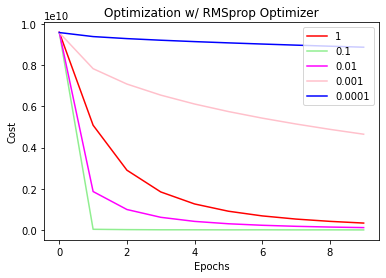

In [19]:
plt.title('Optimization w/ RMSprop Optimizer')
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.plot(costs[0], 'red' , label = learning_rates[0])
plt.plot(costs[1], 'lightgreen', label = learning_rates[1])
plt.plot(costs[2], 'magenta', label = learning_rates[2])
plt.plot(costs[3], 'pink' , label = learning_rates[3])
plt.plot(costs[4], 'blue' , label = learning_rates[4])
plt.legend()
plt.show()

In [20]:
#Optimizing cost function using SGD optimizer and learning rates [ 1, .1, .01, .001, .0001]
costs =[]
epochs = 150
learning_rates = [ .00001 , .00002, .00003, .00004, .000001]       #1, .1, .01, .001,.0001 not good for sgd opt 
for i in learning_rates:
    model = M_Cost().to(device)
    print('Learning Rate:', i)
    optimizer = optim.SGD(model.parameters(), lr = i)
    costs.append(fit(final_X, model, optimizer, epochs))

Learning Rate: 1e-05
Epoch: 0 Loss: 9586598912.0
Epoch: 15 Loss: 59113040.0
Epoch: 30 Loss: 27497696.0
Epoch: 45 Loss: 18840040.0
Epoch: 60 Loss: 14110558.0
Epoch: 75 Loss: 11236703.0
Epoch: 90 Loss: 9342850.0
Epoch: 105 Loss: 8041997.0
Epoch: 120 Loss: 7047913.5
Epoch: 135 Loss: 6270884.0
Learning Rate: 2e-05
Epoch: 0 Loss: 9580048384.0
Epoch: 15 Loss: 19442596.0
Epoch: 30 Loss: 12307116.0
Epoch: 45 Loss: 8699472.0
Epoch: 60 Loss: 6793487.0
Epoch: 75 Loss: 5519164.0
Epoch: 90 Loss: 4680266.0
Epoch: 105 Loss: 4041764.25
Epoch: 120 Loss: 3522302.75
Epoch: 135 Loss: 3096752.0
Learning Rate: 3e-05
Epoch: 0 Loss: 9564936192.0
Epoch: 15 Loss: 21189900.0
Epoch: 30 Loss: 18790706.0
Epoch: 45 Loss: 11868108.0
Epoch: 60 Loss: 14205834.0
Epoch: 75 Loss: 9161812.0
Epoch: 90 Loss: 12485558.0
Epoch: 105 Loss: 7854495.5
Epoch: 120 Loss: 11505931.0
Epoch: 135 Loss: 7083677.0
Learning Rate: 4e-05
Epoch: 0 Loss: 9637671936.0
Epoch: 15 Loss: 32422968.0
Epoch: 30 Loss: 25090096.0
Epoch: 45 Loss: 22608216

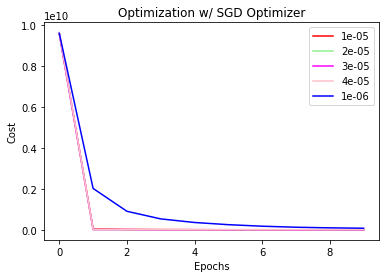

In [21]:
plt.title('Optimization w/ SGD Optimizer')
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.plot(costs[0], 'red' , label = learning_rates[0])
plt.plot(costs[1], 'lightgreen', label = learning_rates[1])
plt.plot(costs[2], 'magenta', label = learning_rates[2])
plt.plot(costs[3], 'pink' , label = learning_rates[3])
plt.plot(costs[4], 'blue' , label = learning_rates[4])
plt.legend()
plt.show()

From the 3 optimizers used, we can see that Adam optimizer yields the best results with a learning rate or 1.

In [25]:
#best model w/ Adam optimizer & lr = 1, increasing num of iterations to see performance
costs_adam =[]
epochs = 301
model = M_Cost().to(device)
print('Adam otimizer & Learning Rate: 1' )
optimizer = optim.Adam(model.parameters(), lr = 1)
costs_adam.append(fit(final_X, model, optimizer, epochs))

#we can see that after around epoch 150, the loss does not decrease significantly anymore. 

Adam otimizer & Learning Rate: 1
Epoch: 0 Loss: 9600951296.0
Epoch: 15 Loss: 342921248.0
Epoch: 30 Loss: 66519316.0
Epoch: 45 Loss: 15944159.0
Epoch: 60 Loss: 6163071.0
Epoch: 75 Loss: 3065186.0
Epoch: 90 Loss: 1732924.125
Epoch: 105 Loss: 1151222.25
Epoch: 120 Loss: 891493.625
Epoch: 135 Loss: 795109.3125
Epoch: 150 Loss: 764337.375
Epoch: 165 Loss: 751261.25
Epoch: 180 Loss: 745388.375
Epoch: 195 Loss: 742453.25
Epoch: 210 Loss: 740713.125
Epoch: 225 Loss: 739509.0
Epoch: 240 Loss: 738559.25
Epoch: 255 Loss: 737736.625
Epoch: 270 Loss: 736994.9375
Epoch: 285 Loss: 736334.9375
Epoch: 300 Loss: 735776.6875


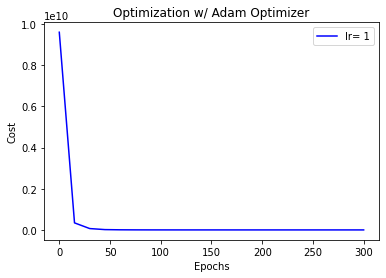

In [26]:
mylist = [num for num in range(0,301) if num%15==0]
plt.title('Optimization w/ Adam Optimizer')
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.plot(mylist, costs_adam[0], 'blue' , label = 'lr= 1')
plt.legend()

In [27]:
#best model w/ Adam optimizer & lr = 1 & 150 epochs
costs_adam =[]
epochs = 150
model = M_Cost().to(device)
print('Adam otimizer & Learning Rate: 1' )
optimizer = optim.Adam(model.parameters(), lr = 1)
costs_adam.append(fit(final_X, model, optimizer, epochs))

Adam otimizer & Learning Rate: 1
Epoch: 0 Loss: 9596155904.0
Epoch: 15 Loss: 343658912.0
Epoch: 30 Loss: 66342736.0
Epoch: 45 Loss: 16001750.0
Epoch: 60 Loss: 6119376.0
Epoch: 75 Loss: 3041000.5
Epoch: 90 Loss: 1712422.75
Epoch: 105 Loss: 1136673.375
Epoch: 120 Loss: 887256.1875
Epoch: 135 Loss: 792831.125


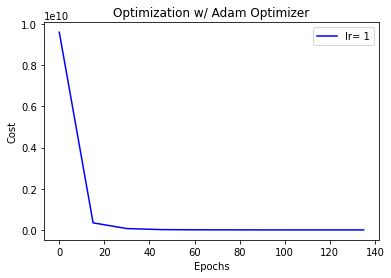

In [45]:
mylist = [num for num in range(0,150) if num%15==0]
plt.title('Optimization w/ Adam Optimizer')
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.plot(mylist, costs_adam[0], 'blue' , label = 'lr= 1')
plt.legend()

In [46]:
#Saving parameters of the model w/ Adam optimizer & lr = 1 
params = [i for i in model.parameters()][0]
params.requires_grad=False

 -  Recommend top 10 movies (not vectors or indices but movie names) given movies (a) _Apollo 13_, (b) _Toy Story_, and (c) _Home Alone_ . Describe your recommendation strategy. Do the recommendations change when you change learning rates or optimizers? Why or why not?

In [55]:
#create a similarity matrix of movies (9742,9742)

print(params.size())
params_transposed = params.transpose(0,1) #9742 X 100 
print(params_transposed.size())
similarity_matrix = torch.mm(params_transposed, params).to(device) 
#matrix multiplication: df_transposed x df (9742,100) x (100 ,9742) = (9742,9742)
print(similarity_matrix.size())

torch.Size([100, 9742])
torch.Size([9742, 100])
torch.Size([9742, 9742])


Using best model w/ Adam optimizer & lr = 1 & 150 epochs

**(a) top 10 movies given the movie Apollo 13** 

In [168]:
#Getting top 10 recommendations given the name of a movie
movies_enumerated = {i: m for i, m in enumerate(movies_df['title'])} #0-9741

# Find index of movie we will give recommendations 
x = movies_df['title'].str.contains('Apollo 13')
index_movie = movies_df.index[x]

#Since we have the index of the movie we are trying to give recommendations, we get the same row from similarity matrix
#so we are getting the similarity scores for all movies when compared to our selected movie
movie_sim_row = similarity_matrix[index_movie]      #[3, 9742]

tensor_values, tensor_indices = torch.topk(input= movie_sim_row, k = 10) #Returns the k largest elements of the given input tensor
#print(torch.topk(input= movie_sim_row, k = 10))
#print(list(enumerate(zip(tensor_values[0], tensor_indices[0]))))

print('Top 10 Movie Recommendations given: Apollo 13')
print('SimScore Name')
for i, (score, index) in enumerate(zip(tensor_values[0], tensor_indices[0])):  # Use dict defined earlier to convert from index to title
  print(np.trunc(score.item()),'\t', movies_enumerated[index.item()])

Top 10 Movie Recommendations given: Apollo 13
SimScore Name
79.0 	 Forrest Gump (1994)
76.0 	 Shawshank Redemption, The (1994)
74.0 	 Apollo 13 (1995)
67.0 	 Pulp Fiction (1994)
64.0 	 Braveheart (1995)
63.0 	 Jurassic Park (1993)
63.0 	 Silence of the Lambs, The (1991)
61.0 	 Fugitive, The (1993)
58.0 	 Terminator 2: Judgment Day (1991)
54.0 	 Lion King, The (1994)


**(b) top 10 movies given the movie Toy Story**

In [163]:
# Find index of movie we will give recommendations 
x = movies_df['title'].str.contains('Toy Story')
index_movie = movies_df.index[x]

#Since we have the index of the movie we are trying to give recommendations, we get the same row from similarity matrix
#so we are getting the similarity scores for all movies when compared to our selected movie
movie_sim_row = similarity_matrix[index_movie]      #[3, 9742]

tensor_values, tensor_indices = torch.topk(input= movie_sim_row, k = 10) #Returns the k largest elements of the given input tensor
#print(torch.topk(input= movie_sim_row, k = 10))

#print(list(enumerate(zip(tensor_values[0], tensor_indices[0]))))

print('Top 10 Movie Recommendations given: Toy Story')
print('SimScore Name')
for i, (score, index) in enumerate(zip(tensor_values[0], tensor_indices[0])):  # Use dict defined earlier to convert from index to title
  print(np.trunc(score.item()),'\t', movies_enumerated[index.item()])

Top 10 Movie Recommendations given: Toy Story
SimScore Name
93.0 	 Toy Story (1995)
86.0 	 Forrest Gump (1994)
82.0 	 Shawshank Redemption, The (1994)
79.0 	 Star Wars: Episode IV - A New Hope (1977)
75.0 	 Pulp Fiction (1994)
71.0 	 Matrix, The (1999)
71.0 	 Silence of the Lambs, The (1991)
69.0 	 Star Wars: Episode V - The Empire Strikes Back (1980)
66.0 	 Jurassic Park (1993)
66.0 	 Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)


**(c) top 10 movies given the movie Home Alone**

In [167]:
# Find index of movie we will give recommendations 
x = movies_df['title'].str.contains('Home Alone')
index_movie = movies_df.index[x]

#Since we have the index of the movie we are trying to give recommendations, we get the same row from similarity matrix
#so we are getting the similarity scores for all movies when compared to our selected movie
movie_sim_row = similarity_matrix[index_movie]      #[3, 9742]

tensor_values, tensor_indices = torch.topk(input= movie_sim_row, k = 10) #Returns the k largest elements of the given input tensor

print('Top 10 Movie Recommendations given: Home Alone')
print('SimScore Name')
for i, (score, index) in enumerate(zip(tensor_values[0], tensor_indices[0])):  # Use dict defined earlier to convert from index to title
  print(np.trunc(score.item()),'\t', movies_enumerated[index.item()])

Top 10 Movie Recommendations given: Home Alone
SimScore Name
28.0 	 Forrest Gump (1994)
24.0 	 Lion King, The (1994)
24.0 	 Jurassic Park (1993)
23.0 	 Terminator 2: Judgment Day (1991)
23.0 	 Toy Story (1995)
22.0 	 Shawshank Redemption, The (1994)
22.0 	 Aladdin (1992)
21.0 	 Silence of the Lambs, The (1991)
21.0 	 Home Alone (1990)
21.0 	 Matrix, The (1999)


###  Do the recommendations change when you change learning rates or optimizers? 


In [171]:
#seeing perfomance using another model that performed well:
#sgd oprimizer, lr=0.00002, 
costs_sgd =[]
epochs = 551
learning_rates = [.00002]
for i in learning_rates:
    model = M_Cost().to(device)
    print('Learning Rate:', i)
    optimizer = optim.SGD(model.parameters(), lr = i)
    costs_sgd.append(fit(final_X, model, optimizer, epochs))

Learning Rate: 2e-05
Epoch: 0 Loss: 9539341312.0
Epoch: 15 Loss: 19439674.0
Epoch: 30 Loss: 12210765.0
Epoch: 45 Loss: 8619027.0
Epoch: 60 Loss: 6710990.5
Epoch: 75 Loss: 5464963.0
Epoch: 90 Loss: 4631396.5
Epoch: 105 Loss: 3998534.25
Epoch: 120 Loss: 3490635.75
Epoch: 135 Loss: 3079640.0
Epoch: 150 Loss: 2743918.5
Epoch: 165 Loss: 2465289.75
Epoch: 180 Loss: 2231368.25
Epoch: 195 Loss: 2034083.125
Epoch: 210 Loss: 1867647.25
Epoch: 225 Loss: 1726946.5
Epoch: 240 Loss: 1607093.375
Epoch: 255 Loss: 1503863.75
Epoch: 270 Loss: 1414022.5
Epoch: 285 Loss: 1335227.25
Epoch: 300 Loss: 1265761.625
Epoch: 315 Loss: 1204316.75
Epoch: 330 Loss: 1149858.0
Epoch: 345 Loss: 1101540.625
Epoch: 360 Loss: 1058648.125
Epoch: 375 Loss: 1020552.75
Epoch: 390 Loss: 986698.125
Epoch: 405 Loss: 956596.75
Epoch: 420 Loss: 929831.5
Epoch: 435 Loss: 906053.25
Epoch: 450 Loss: 884973.1875
Epoch: 465 Loss: 866350.5
Epoch: 480 Loss: 849978.125
Epoch: 495 Loss: 835668.0625
Epoch: 510 Loss: 823241.625
Epoch: 525 Lo

In [173]:
#Save model params
sgd_params = [p for p in model.parameters()][0]
sgd_params.requires_grad=False

#create a similarity matrix of movies (9742,9742)
print(sgd_params.size())
sgd_params_transposed = sgd_params.transpose(0,1) #9742 X 100 
print(sgd_params_transposed.size())
sgd_similarity_matrix = torch.mm(sgd_params_transposed, sgd_params).to(device) 
#matrix multiplication: df_transposed x df (9742,100) x (100 ,9742) = (9742,9742)
print(sgd_similarity_matrix.size())

torch.Size([100, 9742])
torch.Size([9742, 100])
torch.Size([9742, 9742])


In [175]:
# Find index of movie we will give recommendations 
x = movies_df['title'].str.contains('Apollo 13')
index_movie = movies_df.index[x]
#Since we have the index of the movie we are trying to give recommendations, we get the same row from similarity matrix
#so we are getting the similarity scores for all movies when compared to our selected movie
movie_sim_row = sgd_similarity_matrix[index_movie]      #[3, 9742]
tensor_values, tensor_indices = torch.topk(input= movie_sim_row, k = 10) #Returns the k largest elements of the given input tensor
print('Top 10 Movie Recommendations given: Apollo 13')
print('SimScore Name')
for i, (score, index) in enumerate(zip(tensor_values[0], tensor_indices[0])):  # Use dict defined earlier to convert from index to title
  print(np.trunc(score.item()),'\t', movies_enumerated[index.item()])

Top 10 Movie Recommendations given: Apollo 13
SimScore Name
79.0 	 Forrest Gump (1994)
76.0 	 Shawshank Redemption, The (1994)
74.0 	 Apollo 13 (1995)
67.0 	 Pulp Fiction (1994)
64.0 	 Silence of the Lambs, The (1991)
64.0 	 Braveheart (1995)
64.0 	 Jurassic Park (1993)
61.0 	 Fugitive, The (1993)
58.0 	 Terminator 2: Judgment Day (1991)
54.0 	 Lion King, The (1994)


In [176]:
# Find index of movie we will give recommendations 
x = movies_df['title'].str.contains('Toy Story')
index_movie = movies_df.index[x]
#Since we have the index of the movie we are trying to give recommendations, we get the same row from similarity matrix
#so we are getting the similarity scores for all movies when compared to our selected movie
movie_sim_row = sgd_similarity_matrix[index_movie]      #[3, 9742]
tensor_values, tensor_indices = torch.topk(input= movie_sim_row, k = 10) #Returns the k largest elements of the given input tensor
print('Top 10 Movie Recommendations given: Toy Story')
print('SimScore Name')
for i, (score, index) in enumerate(zip(tensor_values[0], tensor_indices[0])):  # Use dict defined earlier to convert from index to title
  print(np.trunc(score.item()),'\t', movies_enumerated[index.item()])

Top 10 Movie Recommendations given: Toy Story
SimScore Name
93.0 	 Toy Story (1995)
84.0 	 Forrest Gump (1994)
83.0 	 Shawshank Redemption, The (1994)
77.0 	 Star Wars: Episode IV - A New Hope (1977)
75.0 	 Pulp Fiction (1994)
71.0 	 Matrix, The (1999)
70.0 	 Silence of the Lambs, The (1991)
68.0 	 Star Wars: Episode V - The Empire Strikes Back (1980)
65.0 	 Jurassic Park (1993)
64.0 	 Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)


In [174]:
# Find index of movie we will give recommendations 
x = movies_df['title'].str.contains('Home Alone')
index_movie = movies_df.index[x]
#Since we have the index of the movie we are trying to give recommendations, we get the same row from similarity matrix
#so we are getting the similarity scores for all movies when compared to our selected movie
movie_sim_row = sgd_similarity_matrix[index_movie]      #[3, 9742]
tensor_values, tensor_indices = torch.topk(input= movie_sim_row, k = 10) #Returns the k largest elements of the given input tensor
print('Top 10 Movie Recommendations given: Home Alone')
print('SimScore Name')
for i, (score, index) in enumerate(zip(tensor_values[0], tensor_indices[0])):  # Use dict defined earlier to convert from index to title
  print(np.trunc(score.item()),'\t', movies_enumerated[index.item()])

Top 10 Movie Recommendations given: Home Alone
SimScore Name
29.0 	 Forrest Gump (1994)
24.0 	 Jurassic Park (1993)
24.0 	 Toy Story (1995)
24.0 	 Lion King, The (1994)
22.0 	 Terminator 2: Judgment Day (1991)
22.0 	 Matrix, The (1999)
22.0 	 Shawshank Redemption, The (1994)
21.0 	 Aladdin (1992)
21.0 	 Silence of the Lambs, The (1991)
20.0 	 Home Alone (1990)


We can see the recommendations using a different optimizer for Apollo 13, Toy Story, and Home Alone are the same 10 movies, scores differ but not significantly. Rank of recommendations is almost the same as well. 